<a href="https://colab.research.google.com/github/SofiaIPalladino/AI/blob/main/TPFinal/TPFinal_Inteligencia_Artificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install visualkeras
!pip install pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 12.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import os
import numpy as np

In [3]:
drive.mount('/content/drive')

# Definir rutas globales
UNET_DATASET_PATH = '/content/drive/My Drive/cancer/Unet'
CLASSIFICATION_DATASET_PATH = '/content/drive/My Drive/cancer/Clasifica'


Mounted at /content/drive


In [4]:
%ls /content/drive/My\ Drive/cancer/Unet

checkpoints/  images/  masks/  processed_data/


### ***Unet***

### Carga de datos


In [5]:
def load_data_unet(img_size=224):
    """
    Carga simple de imágenes y máscaras
    """
    # Definir rutas
    image_path = os.path.join(UNET_DATASET_PATH, 'images')
    mask_path = os.path.join(UNET_DATASET_PATH, 'masks')

    # Obtener lista de imágenes
    image_files = sorted([f for f in os.listdir(image_path) if f.endswith('.jpg')])
    print(f"Total de imágenes encontradas: {len(image_files)}")

    # Preparar listas para almacenar datos
    images = []
    masks = []

    # Cargar imágenes y máscaras
    for img_file in tqdm(image_files, desc="Cargando imágenes"):
        # Obtener nombre base
        base_name = img_file.replace('.jpg', '')
        mask_file = base_name + '_segmentation.png'

        # Verificar si existe la máscara
        if not os.path.exists(os.path.join(mask_path, mask_file)):
            continue

        try:
            # Cargar imagen
            img = load_img(os.path.join(image_path, img_file),
                         target_size=(img_size, img_size))
            img_arr = img_to_array(img) / 255.0

            # Cargar máscara
            mask = load_img(os.path.join(mask_path, mask_file),
                          target_size=(img_size, img_size),
                          color_mode='grayscale')
            mask_arr = img_to_array(mask) / 255.0

            images.append(img_arr)
            masks.append(mask_arr)

        except Exception as e:
            print(f"Error al cargar {img_file}: {str(e)}")
            continue

    # Convertir a arrays
    images = np.array(images)
    masks = np.array(masks)

    print(f"\nDatos cargados:")
    print(f"Imágenes: {images.shape}")
    print(f"Máscaras: {masks.shape}")

    return images, masks

def prepare_datasets_unet(batch_size=8, img_size=224, validation_split=0.2):
    """
    Prepara los datasets de entrenamiento y validación
    """
    print("Cargando datos...")
    images, masks = load_data_unet(img_size)

    # Dividir en entrenamiento y validación
    split_idx = int(len(images) * (1 - validation_split))

    train_images = images[:split_idx]
    train_masks = masks[:split_idx]
    val_images = images[split_idx:]
    val_masks = masks[split_idx:]

    # Crear datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))

    # Configurar para entrenamiento
    train_dataset = train_dataset.shuffle(1000).batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    # Calcular pasos
    steps_per_epoch = len(train_images) // batch_size
    validation_steps = len(val_images) // batch_size

    print(f"\nConfiguración del entrenamiento:")
    print(f"Imágenes de entrenamiento: {len(train_images)}")
    print(f"Imágenes de validación: {len(val_images)}")
    print(f"Pasos por época: {steps_per_epoch}")
    print(f"Pasos de validación: {validation_steps}")

    return train_dataset, val_dataset, steps_per_epoch, validation_steps

### Guardado de datos en GDrive

In [6]:
import h5py

def save_existing_datasets_to_drive_unet(train_ds, val_ds, save_path='/content/drive/My Drive/cancer/Unet/processed_data'):
    """
    Guarda los datasets existentes en Google Drive
    """
    print("Montando Google Drive...")
    drive.mount('/content/drive')

    # Crear directorio si no existe
    os.makedirs(save_path, exist_ok=True)

    print("\nPreparando datos para guardar...")

    # Extraer datos de los datasets
    print("Extrayendo imágenes y máscaras de los datasets...")

    # Para el conjunto de entrenamiento
    train_images = []
    train_masks = []
    for images, masks in train_ds:
        train_images.append(images.numpy())
        train_masks.append(masks.numpy())

    train_images = np.concatenate(train_images, axis=0)
    train_masks = np.concatenate(train_masks, axis=0)

    # Para el conjunto de validación
    val_images = []
    val_masks = []
    for images, masks in val_ds:
        val_images.append(images.numpy())
        val_masks.append(masks.numpy())

    val_images = np.concatenate(val_images, axis=0)
    val_masks = np.concatenate(val_masks, axis=0)

    print("\nFormas de los arrays:")
    print(f"Train images: {train_images.shape}")
    print(f"Train masks: {train_masks.shape}")
    print(f"Val images: {val_images.shape}")
    print(f"Val masks: {val_masks.shape}")

    # Guardar en archivo H5
    h5_path = os.path.join(save_path, 'segmentation_datasets.h5')
    print(f"\nGuardando datasets en: {h5_path}")

    with h5py.File(h5_path, 'w') as hf:
        # Crear datasets con compresión
        print("Guardando conjunto de entrenamiento...")
        hf.create_dataset('train_images', data=train_images, compression='gzip', compression_opts=9)
        hf.create_dataset('train_masks', data=train_masks, compression='gzip', compression_opts=9)

        print("Guardando conjunto de validación...")
        hf.create_dataset('val_images', data=val_images, compression='gzip', compression_opts=9)
        hf.create_dataset('val_masks', data=val_masks, compression='gzip', compression_opts=9)

        # Guardar metadatos
        hf.attrs['train_size'] = len(train_images)
        hf.attrs['val_size'] = len(val_images)
        hf.attrs['img_shape'] = train_images.shape[1:]

    print("\nDatasets guardados exitosamente!")
    print(f"Ubicación: {h5_path}")

    # Verificar que se guardó correctamente
    print("\nVerificando archivo guardado...")
    with h5py.File(h5_path, 'r') as hf:
        print("\nConjuntos de datos en el archivo:")
        for key in hf.keys():
            print(f"{key}: {hf[key].shape}")


def load_datasets_from_drive_unet(batch_size=8):
    with h5py.File('/content/drive/My Drive/cancer/Unet/processed_data/segmentation_datasets.h5', 'r') as hf:
        train_images = hf['train_images'][:]
        train_masks = hf['train_masks'][:]
        val_images = hf['val_images'][:]
        val_masks = hf['val_masks'][:]

        # Crear tf.data.Datasets
        train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
        val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))

        # Configurar datasets
        train_ds = train_ds.shuffle(1000).batch(batch_size)
        val_ds = val_ds.batch(batch_size)

        return train_ds, val_ds

In [7]:
def verify_saved_datasets_unet(file_path='/content/drive/My Drive/cancer/Unet/processed_data/segmentation_datasets.h5', num_samples=3):
    """
    Verifica la integridad de los datasets guardados y muestra algunas muestras
    """
    # Montar Google Drive si no está montado
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    print(f"Verificando archivo: {file_path}")

    try:
        with h5py.File(file_path, 'r') as hf:
            # 1. Verificar estructura del archivo
            print("\n1. Estructura del archivo:")
            print("Datasets encontrados:")
            for key in hf.keys():
                data = hf[key]
                print(f"- {key}: shape={data.shape}, dtype={data.dtype}")

            # 2. Verificar rangos de valores
            print("\n2. Rangos de valores:")
            for key in ['train_images', 'train_masks', 'val_images', 'val_masks']:
                data = hf[key][:]
                print(f"{key}:")
                print(f"  - Min: {data.min():.3f}")
                print(f"  - Max: {data.max():.3f}")
                print(f"  - Media: {data.mean():.3f}")
                print(f"  - % de ceros: {(data == 0).mean() * 100:.1f}%")

            # 3. Visualizar algunas muestras
            print(f"\n3. Visualizando {num_samples} muestras aleatorias...")

            # Seleccionar índices aleatorios
            total_samples = hf['train_images'].shape[0]
            random_indices = np.random.choice(total_samples, num_samples, replace=False)

            # Crear subplot
            fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))

            for idx, i in enumerate(random_indices):
                # Imagen original
                img = hf['train_images'][i]
                mask = hf['train_masks'][i]

                # Mostrar imagen
                axes[idx, 0].imshow(img)
                axes[idx, 0].set_title(f'Imagen {i}')
                axes[idx, 0].axis('off')

                # Mostrar máscara
                axes[idx, 1].imshow(mask[:,:,0], cmap='gray')
                axes[idx, 1].set_title(f'Máscara {i}')
                axes[idx, 1].axis('off')

            plt.tight_layout()
            plt.show()

            print("\nVerificación completa!")
            print(f"- Total de imágenes de entrenamiento: {hf['train_images'].shape[0]}")
            print(f"- Total de imágenes de validación: {hf['val_images'].shape[0]}")

            return True

    except Exception as e:
        print(f"Error al verificar el archivo: {str(e)}")
        return False

# Uso de la función
"""
verify_saved_datasets(num_samples=3)
"""

'\nverify_saved_datasets(num_samples=3)\n'


### Definicion de red Unet


In [8]:
def create_unet(img_size=224):
    """
    Crea el modelo U-Net para segmentación
    """
    inputs = layers.Input((img_size, img_size, 3))

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)

    # Decoder
    up5 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(drop4)
    up5 = layers.concatenate([up5, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [9]:
def train_unet(model, train_ds, val_ds):
    """
    Entrena el modelo U-Net con configuración automática de parámetros

    Parámetros:
    - model: modelo U-Net a entrenar
    - train_ds: dataset de entrenamiento
    - val_ds: dataset de validación
    """
    # Calcular steps automáticamente
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    validation_steps = tf.data.experimental.cardinality(val_ds).numpy()

    # Configurar parámetros de entrenamiento
    EPOCHS = 50  # Más épocas ya que tenemos early stopping
    BATCH_SIZE = 8  # Tamaño de batch estándar
    INITIAL_LR = 1e-4  # Learning rate inicial

    # Compilar el modelo con métricas
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(), Recall(), 'AUC']
    )

    # Crear directorio para checkpoints
    checkpoint_dir = '/content/drive/My Drive/cancer/Unet/checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Callbacks
    callbacks = [
        # Guardar mejor modelo
        ModelCheckpoint(
            os.path.join(checkpoint_dir, 'best_unet.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        # Early stopping
        EarlyStopping(
            monitor='val_loss',
            patience=15,  # Más paciencia para evitar parada prematura
            restore_best_weights=True,
            verbose=1
        ),
        # Reducción de learning rate
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=1
        )
    ]

    print(f"Iniciando entrenamiento con:")
    print(f"- Steps por época: {steps_per_epoch}")
    print(f"- Steps de validación: {validation_steps}")
    print(f"- Learning rate inicial: {INITIAL_LR}")
    print(f"- Batch size: {BATCH_SIZE}")
    print(f"- Épocas máximas: {EPOCHS}")

    # Entrenar el modelo
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks
    )

    # Visualizar resultados
    def plot_training_history_unet(history):
        metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
        fig, axes = plt.subplots(3, 2, figsize=(15, 18))
        axes = axes.ravel()

        for idx, metric in enumerate(metrics):
            if metric in history.history:
                axes[idx].plot(
                    history.history[metric],
                    label=f'Training {metric.capitalize()}'
                )
                axes[idx].plot(
                    history.history[f'val_{metric}'],
                    label=f'Validation {metric.capitalize()}'
                )
                axes[idx].set_title(f'Model {metric.capitalize()}')
                axes[idx].set_xlabel('Epoch')
                axes[idx].set_ylabel(metric.capitalize())
                axes[idx].legend()
                axes[idx].grid(True)

        plt.tight_layout()
        plt.show()

    # Mostrar gráficas
    plot_training_history_unet(history)

    # Imprimir resumen del entrenamiento
    print("\nResumen del entrenamiento:")
    print(f"Épocas completadas: {len(history.history['loss'])}")
    print(f"Mejor precisión de validación: {max(history.history['val_accuracy']):.4f}")
    print(f"Mejor AUC de validación: {max(history.history['val_auc']):.4f}")
    print(f"Mejor precisión (precision) de validación: {max(history.history['val_precision']):.4f}")
    print(f"Mejor recall de validación: {max(history.history['val_recall']):.4f}")
    print(f"Pérdida final de validación: {min(history.history['val_loss']):.4f}")

    return history, model

# Ejemplo de uso:
# history, trained_model = train_unet(model, train_ds, val_ds)

In [10]:
def load_pretrained_unet(checkpoint_path='/content/drive/My Drive/cancer/Unet/checkpoints/best_unet.keras'):
    """
    Carga el modelo U-Net pre-entrenado

    Args:
        checkpoint_path: Ruta al archivo de checkpoint de U-Net

    Returns:
        model: Modelo U-Net con pesos pre-entrenados
    """
    try:
        print("Cargando modelo U-Net pre-entrenado...")

        # Crear modelo U-Net base
        unet_model = create_unet()

        # Configurar parámetros
        INITIAL_LR = 1e-4

        # Compilar modelo U-Net con las mismas métricas del entrenamiento
        unet_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
            loss='binary_crossentropy',
            metrics=['accuracy', Precision(), Recall(), 'AUC']
        )

        # Cargar pesos
        unet_model.load_weights(checkpoint_path)
        print("✓ Modelo U-Net cargado exitosamente!")

        return unet_model

    except Exception as e:
        print(f"❌ Error al cargar modelo U-Net: {str(e)}")
        return None

### Bloque principal Unet



In [11]:
import visualkeras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

print("Entrenando U-Net para segmentación...")
unet_model = create_unet()
unet_model.summary()

plot_model(
    unet_model,
    to_file="Unet_architecture.png",
    show_shapes=True,
    show_layer_names=True
)


visualkeras.layered_view(unet_model, legend=True).save("Unet_diagram.png")


Entrenando U-Net para segmentación...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 28, 28, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 56, 56, 256)    │        524,544 │ dropout[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 56, 56, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 56, 56, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ conv2d_8[0][0]         │
├──────────────────────

 Total params: 7,697,345 (29.36 MB)

 Trainable params: 7,697,345 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [ ]:
"""
Si no tenemos un archivo segmention_data.h5 usar esta funcion
"""

print("Cargando los datos para el entrenamiento de la Unet...")

train_ds, val_ds, steps_epoch, val_steps = prepare_datasets_unet(
    batch_size=8,
    img_size=224
)


In [ ]:
"""
Ejecutar esto si necesitas guardar nuevos datasets en Google Drive
"""
#save_existing_datasets_to_drive_unet(train_ds, val_ds)

In [14]:
"""
Ejecutar esto para levantar el dataset de googledrive
"""

#train_ds, val_ds=load_datasets_from_drive_unet(batch_size=8)

'\nEjecutar esto para levantar el dataset de googledrive\n'

In [15]:
"""
Verifico la integridad de los dataset guardados en memoria
"""
#verify_saved_datasets_unet(num_samples=3)

'\nVerifico la integridad de los dataset guardados en memoria\n'


3. Entrenando U-Net...
Iniciando entrenamiento con:
- Steps por época: 230
- Steps de validación: 58
- Learning rate inicial: 0.0001
- Batch size: 8
- Épocas máximas: 100
Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - AUC: 0.7187 - accuracy: 0.7585 - loss: 0.5227 - precision: 0.5842 - recall: 0.1483
Epoch 1: val_accuracy improved from -inf to 0.87246, saving model to /content/drive/My Drive/cancer/Unet/checkpoints/best_unet.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 176s 559ms/step - AUC: 0.7191 - accuracy: 0.7587 - loss: 0.5224 - precision: 0.5852 - recall: 0.1491 - val_AUC: 0.9392 - val_accuracy: 0.8725 - val_loss: 0.3043 - val_precision: 0.9848 - val_recall: 0.5006 - learning_rate: 1.0000e-04
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - AUC: 0.8930 - accuracy: 0.8544 - loss: 0.3436 - precision: 0.8488 - recall: 0.5581
Epoch 2: val_accuracy did not improve from 0.87246
230/230 ━━━━━━━━━━━━━━━━━━━━ 71s 308ms/step - AUC: 0.8931 - accuracy: 0.8545 - loss: 0.3435 - precisi

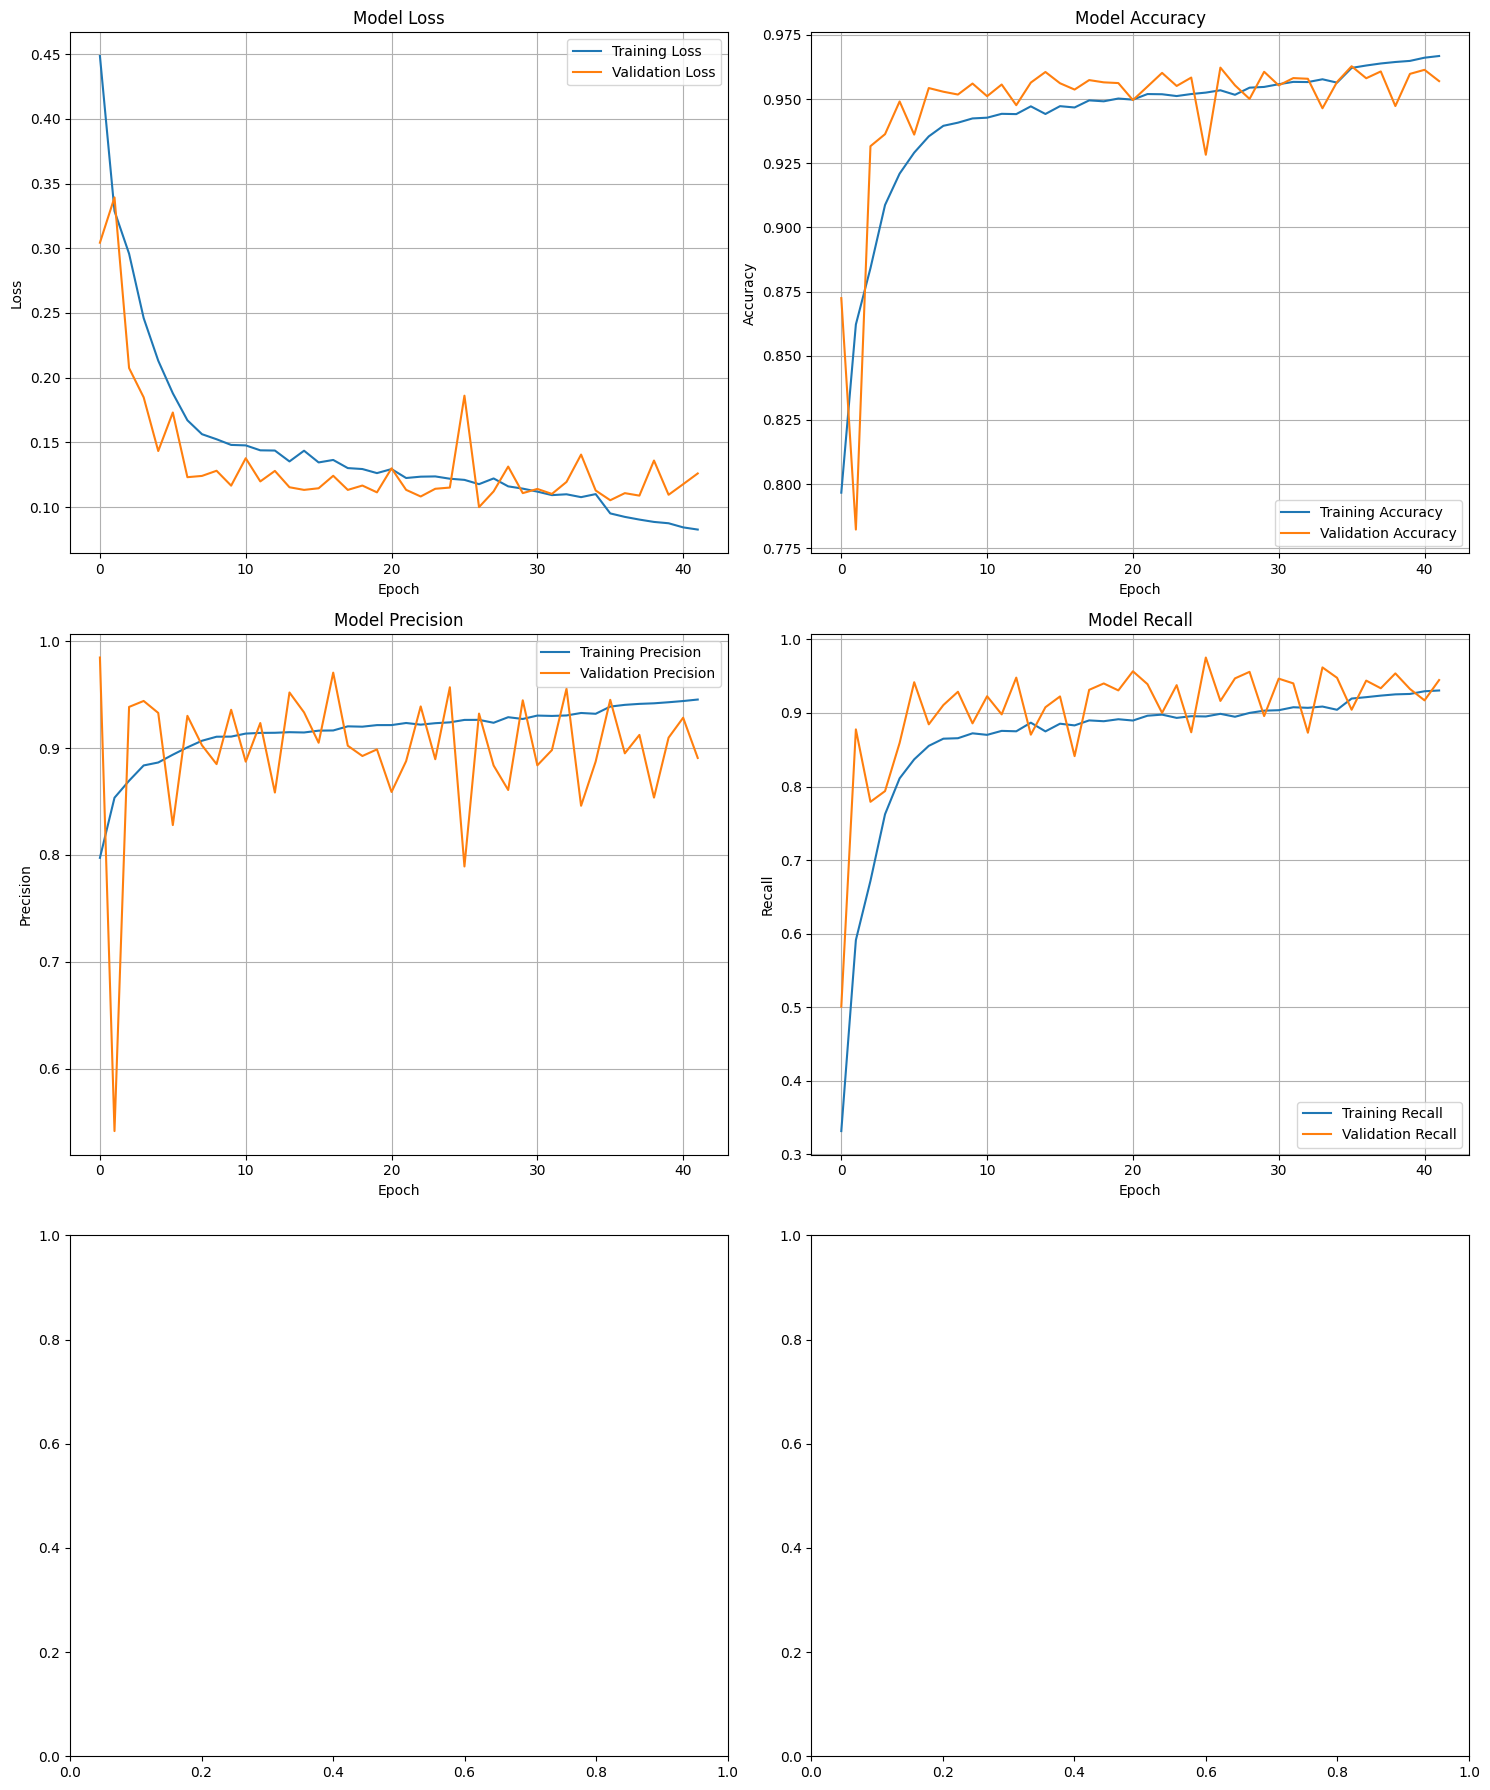


Resumen del entrenamiento:
Épocas completadas: 42
Mejor precisión de validación: 0.9628


KeyError: 'val_auc'

In [ ]:
print("\n3. Entrenando U-Net...")
history, trained_unet_model = train_unet(unet_model, train_ds, val_ds)
print("Entrenamiento de U-Net completado")

###

### Cargar red Unet de Gdrive


In [16]:
trained_unet_model = load_pretrained_unet()


Cargando modelo U-Net pre-entrenado...
✓ Modelo U-Net cargado exitosamente!


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [39]:
from IPython.display import display, HTML
from google.colab import files
import tempfile
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def predict_unet_output(unet_model, img_size=224):
    """
    Permite subir una imagen desde el computador local a Colab y realiza la predicción de la máscara con una U-Net.

    Args:
        unet_model: Modelo U-Net entrenado.
        img_size: Tamaño de la imagen esperado por el modelo.
    """
    try:
        # Mostrar mensaje de carga
        display(HTML(
            '<div style="background-color:#f8f9fa;padding:10px;border-radius:5px;margin:10px 0;">'
            '<h3 style="color:#0056b3;margin:0;">📁 Selecciona una imagen para analizar</h3>'
            '<p style="margin:5px 0 0 0;">Formatos soportados: jpg, jpeg, png</p>'
            '</div>'
        ))

        # Subir archivo
        uploaded = files.upload()

        if not uploaded:
            print("No se seleccionó ninguna imagen.")
            return None

        # Procesar cada imagen subida (normalmente será una)
        results = []
        for filename, content in uploaded.items():
            # Guardar archivo temporalmente
            with tempfile.NamedTemporaryFile(delete=False, suffix=os.path.splitext(filename)[1]) as tmp_file:
                tmp_file.write(content)
                temp_path = tmp_file.name

            try:
                # Cargar y preprocesar la imagen
                img = tf.keras.preprocessing.image.load_img(
                    temp_path,
                    target_size=(img_size, img_size)
                )
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = img_array / 255.0
                img_array = np.expand_dims(img_array, axis=0)

                # Realizar predicción
                mask_prediction = unet_model.predict(img_array, verbose=0)[0]
                mask_prediction = np.squeeze(mask_prediction)

                # Visualizar resultados
                plt.figure(figsize=(12, 6))

                # Mostrar imagen original
                plt.subplot(1, 2, 1)
                plt.imshow(img)
                plt.title("Imagen Original")
                plt.axis('off')

                # Mostrar máscara predicha
                plt.subplot(1, 2, 2)
                plt.imshow(mask_prediction, cmap='gray')
                plt.title("Máscara Predicha")
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                # Guardar resultados
                results.append({
                    "filename": filename,
                    "mask": mask_prediction
                })

            except Exception as e:
                print(f"\n❌ Error al procesar {filename}: {str(e)}")

            finally:
                # Limpiar archivo temporal
                os.unlink(temp_path)

        return results[0] if len(results) == 1 else results

    except Exception as e:
        print(f"\n❌ Error general: {str(e)}")
        return None


Saving 216.jpg to 216 (1).jpg


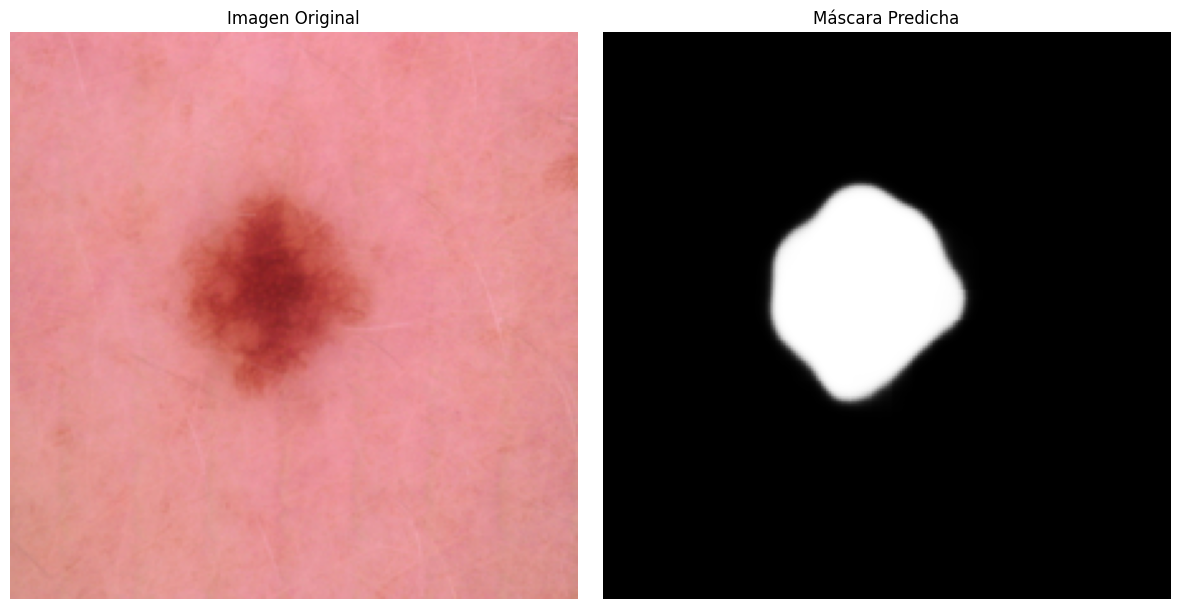

{'filename': '216 (1).jpg',
 'mask': array([[4.0661152e-03, 9.2101324e-04, 3.8450409e-04, ..., 5.5811316e-04,
         1.4492299e-03, 7.8718867e-03],
        [6.2150444e-04, 2.3459729e-04, 1.2762684e-04, ..., 2.7144040e-04,
         4.7705078e-04, 1.3126850e-03],
        [2.5310402e-04, 1.1126772e-04, 6.6223765e-05, ..., 1.4339766e-04,
         2.2353610e-04, 5.0981721e-04],
        ...,
        [4.8428829e-04, 2.9792549e-04, 1.8723702e-04, ..., 4.3298840e-04,
         8.0018298e-04, 1.4664431e-03],
        [1.1716359e-03, 6.0921634e-04, 3.6540831e-04, ..., 6.9399562e-04,
         1.3782431e-03, 3.0588692e-03],
        [5.2991784e-03, 1.2400231e-03, 5.5403786e-04, ..., 1.1274160e-03,
         3.3153580e-03, 9.0204002e-03]], dtype=float32)}

In [40]:
predict_unet_output(trained_unet_model)

### Clasificadora


### Carga de datos


In [17]:
def load_data_clasificion(img_size=224):
    """
    Carga de imágenes para clasificación binaria (maligno/benigno)
    """
    # Definir rutas
    maligno_path = os.path.join(CLASSIFICATION_DATASET_PATH, 'maligno')
    benigno_path = os.path.join(CLASSIFICATION_DATASET_PATH, 'benigno')

    # Obtener lista de imágenes
    maligno_files = sorted([f for f in os.listdir(maligno_path) if f.endswith('.jpg')])
    benigno_files = sorted([f for f in os.listdir(benigno_path) if f.endswith('.jpg')])

    print(f"Total de imágenes malignas encontradas: {len(maligno_files)}")
    print(f"Total de imágenes benignas encontradas: {len(benigno_files)}")

    # Preparar listas para almacenar datos
    images = []
    labels = []  # 1 para maligno, 0 para benigno

    # Cargar imágenes malignas
    for img_file in tqdm(maligno_files, desc="Cargando imágenes malignas"):
        try:
            # Cargar imagen
            img = load_img(os.path.join(maligno_path, img_file),
                         target_size=(img_size, img_size))
            img_arr = img_to_array(img) / 255.0

            images.append(img_arr)
            labels.append(1)  # Etiqueta para maligno

        except Exception as e:
            print(f"Error al cargar {img_file}: {str(e)}")
            continue

    # Cargar imágenes benignas
    for img_file in tqdm(benigno_files, desc="Cargando imágenes benignas"):
        try:
            # Cargar imagen
            img = load_img(os.path.join(benigno_path, img_file),
                         target_size=(img_size, img_size))
            img_arr = img_to_array(img) / 255.0

            images.append(img_arr)
            labels.append(0)  # Etiqueta para benigno

        except Exception as e:
            print(f"Error al cargar {img_file}: {str(e)}")
            continue

    # Convertir a arrays
    images = np.array(images)
    labels = np.array(labels)

    print(f"\nDatos cargados:")
    print(f"Imágenes: {images.shape}")
    print(f"Etiquetas: {labels.shape}")

    return images, labels

def prepare_datasets_clasificion(batch_size=32, img_size=224, validation_split=0.2):
    """
    Prepara los datasets de entrenamiento y validación para clasificación
    """
    print("Cargando datos...")
    images, labels = load_data_clasificion(img_size)

    # Mezclar los datos
    indices = np.random.permutation(len(images))
    images = images[indices]
    labels = labels[indices]

    # Dividir en entrenamiento y validación
    split_idx = int(len(images) * (1 - validation_split))

    train_images = images[:split_idx]
    train_labels = labels[:split_idx]
    val_images = images[split_idx:]
    val_labels = labels[split_idx:]

    # Crear datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Configurar para entrenamiento
    train_dataset = (train_dataset
                    .shuffle(1000)
                    .batch(batch_size)
                    .prefetch(tf.data.AUTOTUNE))
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Calcular pasos
    steps_per_epoch = len(train_images) // batch_size
    validation_steps = len(val_images) // batch_size

    print(f"\nConfiguración del entrenamiento:")
    print(f"Imágenes de entrenamiento: {len(train_images)}")
    print(f"Imágenes de validación: {len(val_images)}")
    print(f"Distribución de clases en entrenamiento:")
    print(f"  Maligno: {np.sum(train_labels == 1)}")
    print(f"  Benigno: {np.sum(train_labels == 0)}")
    print(f"Pasos por época: {steps_per_epoch}")
    print(f"Pasos de validación: {validation_steps}")

    return train_dataset, val_dataset, steps_per_epoch, validation_steps

### Guardar dataset en gdrive


In [18]:
import h5py
from google.colab import drive

def save_existing_datasets_to_drive_clasificion(train_ds, val_ds, save_path='/content/drive/My Drive/cancer/Clasifica/processed_data'):
    """
    Guarda los datasets de clasificación existentes en Google Drive
    """
    print("Montando Google Drive...")
    drive.mount('/content/drive')

    # Crear directorio si no existe
    os.makedirs(save_path, exist_ok=True)

    print("\nPreparando datos para guardar...")

    # Extraer datos de los datasets
    print("Extrayendo imágenes y etiquetas de los datasets...")

    # Para el conjunto de entrenamiento
    train_images = []
    train_labels = []
    for images, labels in train_ds:
        train_images.append(images.numpy())
        train_labels.append(labels.numpy())

    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # Para el conjunto de validación
    val_images = []
    val_labels = []
    for images, labels in val_ds:
        val_images.append(images.numpy())
        val_labels.append(labels.numpy())

    val_images = np.concatenate(val_images, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)

    print("\nFormas de los arrays:")
    print(f"Train images: {train_images.shape}")
    print(f"Train labels: {train_labels.shape}")
    print(f"Val images: {val_images.shape}")
    print(f"Val labels: {val_labels.shape}")

    # Estadísticas de clases
    print("\nDistribución de clases:")
    print("Entrenamiento:")
    print(f"  Maligno: {np.sum(train_labels == 1)}")
    print(f"  Benigno: {np.sum(train_labels == 0)}")
    print("Validación:")
    print(f"  Maligno: {np.sum(val_labels == 1)}")
    print(f"  Benigno: {np.sum(val_labels == 0)}")

    # Guardar en archivo H5
    h5_path = os.path.join(save_path, 'classification_datasets.h5')
    print(f"\nGuardando datasets en: {h5_path}")

    with h5py.File(h5_path, 'w') as hf:
        # Crear datasets con compresión
        print("Guardando conjunto de entrenamiento...")
        hf.create_dataset('train_images', data=train_images, compression='gzip', compression_opts=9)
        hf.create_dataset('train_labels', data=train_labels, compression='gzip', compression_opts=9)

        print("Guardando conjunto de validación...")
        hf.create_dataset('val_images', data=val_images, compression='gzip', compression_opts=9)
        hf.create_dataset('val_labels', data=val_labels, compression='gzip', compression_opts=9)

        # Guardar metadatos
        hf.attrs['train_size'] = len(train_images)
        hf.attrs['val_size'] = len(val_images)
        hf.attrs['img_shape'] = train_images.shape[1:]
        hf.attrs['num_classes'] = 2  # Binario: maligno/benigno

    print("\nDatasets guardados exitosamente!")
    print(f"Ubicación: {h5_path}")

    # Verificar que se guardó correctamente
    print("\nVerificando archivo guardado...")
    with h5py.File(h5_path, 'r') as hf:
        print("\nConjuntos de datos en el archivo:")
        for key in hf.keys():
            print(f"{key}: {hf[key].shape}")

def load_datasets_from_drive_clasificion(batch_size=32):
    """
    Carga los datasets de clasificación desde Google Drive
    """
    with h5py.File('/content/drive/My Drive/cancer/Clasifica/processed_data/classification_datasets.h5', 'r') as hf:
        train_images = hf['train_images'][:]
        train_labels = hf['train_labels'][:]
        val_images = hf['val_images'][:]
        val_labels = hf['val_labels'][:]

        print("Distribución de clases:")
        print("Entrenamiento:")
        print(f"  Maligno: {np.sum(train_labels == 1)}")
        print(f"  Benigno: {np.sum(train_labels == 0)}")
        print("Validación:")
        print(f"  Maligno: {np.sum(val_labels == 1)}")
        print(f"  Benigno: {np.sum(val_labels == 0)}")

        # Crear tf.data.Datasets
        train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
        val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

        # Configurar datasets
        train_ds = (train_ds
                   .shuffle(1000)
                   .batch(batch_size)
                   .prefetch(tf.data.AUTOTUNE))
        val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return train_ds, val_ds

In [19]:
def verify_saved_datasets_classification(file_path='/content/drive/My Drive/cancer/Clasifica/processed_data/classification_datasets.h5', num_samples=3):
    """
    Verifica la integridad de los datasets de clasificación guardados y muestra algunas muestras
    """
    # Montar Google Drive si no está montado
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    print(f"Verificando archivo: {file_path}")

    try:
        with h5py.File(file_path, 'r') as hf:
            # 1. Verificar estructura del archivo
            print("\n1. Estructura del archivo:")
            print("Datasets encontrados:")
            for key in hf.keys():
                data = hf[key]
                print(f"- {key}: shape={data.shape}, dtype={data.dtype}")

            # 2. Verificar rangos de valores
            print("\n2. Rangos de valores:")
            # Verificar imágenes
            for key in ['train_images', 'val_images']:
                data = hf[key][:]
                print(f"{key}:")
                print(f"  - Min: {data.min():.3f}")
                print(f"  - Max: {data.max():.3f}")
                print(f"  - Media: {data.mean():.3f}")
                print(f"  - Desv. Est.: {data.std():.3f}")

            # Verificar etiquetas
            print("\n3. Distribución de clases:")
            train_labels = hf['train_labels'][:]
            val_labels = hf['val_labels'][:]

            print("Entrenamiento:")
            print(f"  - Total muestras: {len(train_labels)}")
            print(f"  - Maligno (1): {np.sum(train_labels == 1)} ({np.mean(train_labels == 1)*100:.1f}%)")
            print(f"  - Benigno (0): {np.sum(train_labels == 0)} ({np.mean(train_labels == 0)*100:.1f}%)")

            print("\nValidación:")
            print(f"  - Total muestras: {len(val_labels)}")
            print(f"  - Maligno (1): {np.sum(val_labels == 1)} ({np.mean(val_labels == 1)*100:.1f}%)")
            print(f"  - Benigno (0): {np.sum(val_labels == 0)} ({np.mean(val_labels == 0)*100:.1f}%)")

            # 4. Visualizar algunas muestras
            print(f"\n4. Visualizando {num_samples} muestras aleatorias de cada clase...")

            # Seleccionar índices aleatorios para cada clase
            train_malignant_idx = np.where(train_labels == 1)[0]
            train_benign_idx = np.where(train_labels == 0)[0]

            malignant_samples = np.random.choice(train_malignant_idx, num_samples, replace=False)
            benign_samples = np.random.choice(train_benign_idx, num_samples, replace=False)

            # Crear subplot
            fig, axes = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))

            # Mostrar muestras malignas
            for idx, i in enumerate(malignant_samples):
                img = hf['train_images'][i]
                axes[0, idx].imshow(img)
                axes[0, idx].set_title(f'Maligno\nÍndice: {i}')
                axes[0, idx].axis('off')

            # Mostrar muestras benignas
            for idx, i in enumerate(benign_samples):
                img = hf['train_images'][i]
                axes[1, idx].imshow(img)
                axes[1, idx].set_title(f'Benigno\nÍndice: {i}')
                axes[1, idx].axis('off')

            plt.tight_layout()
            plt.show()

            # 5. Verificar metadatos
            print("\n5. Metadatos del archivo:")
            for key in hf.attrs.keys():
                print(f"- {key}: {hf.attrs[key]}")

            print("\nVerificación completa!")
            return True

    except Exception as e:
        print(f"Error al verificar el archivo: {str(e)}")
        return False

# Ejemplo de uso
"""
verify_saved_datasets_classification(num_samples=3)
"""

'\nverify_saved_datasets_classification(num_samples=3)\n'

In [29]:
def load_pretrained_combined_model(checkpoint_path='/content/drive/MyDrive/cancer/Clasifica/checkpoints/best_combined_model.keras'):
    """
    Carga el modelo combinado pre-entrenado

    Args:
        checkpoint_path: Ruta al archivo de checkpoint del modelo combinado

    Returns:
        model: Modelo combinado con pesos pre-entrenados
    """
    try:
        print("Cargando modelo combinado pre-entrenado...")

        # Primero cargar U-Net pre-entrenado
        unet_model = load_pretrained_unet()
        if unet_model is None:
            raise Exception("No se pudo cargar el modelo U-Net base")

        # Crear modelo combinado
        combined_model = create_combined_model(unet_model)

        # Configurar parámetros
        INITIAL_LR = 1e-4

        # Compilar modelo combinado con las mismas métricas del entrenamiento
        combined_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')
            ]
        )

        # Cargar pesos del modelo combinado
        combined_model.load_weights(checkpoint_path)
        print("✓ Modelo combinado cargado exitosamente!")

        return combined_model

    except Exception as e:
        print(f"❌ Error al cargar modelo combinado: {str(e)}")
        return None

### aca carga los dataset

In [ ]:
"""
Preparo los datasets de clasificación (si no lo tengo en gdrive)
"""

clas_trin_dataset, clas_val_dataset, clas_steps_epoch, clas_val_steps = prepare_datasets_clasificion()

Cargando datos...
Total de imágenes malignas encontradas: 1197
Total de imágenes benignas encontradas: 1440


Cargando imágenes benignas: 100%|██████████| 1440/1440 [00:12<00:00, 116.48it/s]



Datos cargados:
Imágenes: (2637, 224, 224, 3)
Etiquetas: (2637,)

Configuración del entrenamiento:
Imágenes de entrenamiento: 2109
Imágenes de validación: 528
Distribución de clases en entrenamiento:
  Maligno: 951
  Benigno: 1158
Pasos por época: 65
Pasos de validación: 16


In [ ]:
"""
Para guardar los dataset en grdrive
"""
save_existing_datasets_to_drive_clasificion(clas_trin_dataset, clas_val_dataset)

Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Preparando datos para guardar...
Extrayendo imágenes y etiquetas de los datasets...

Formas de los arrays:
Train images: (2109, 224, 224, 3)
Train labels: (2109,)
Val images: (528, 224, 224, 3)
Val labels: (528,)

Distribución de clases:
Entrenamiento:
  Maligno: 951
  Benigno: 1158
Validación:
  Maligno: 246
  Benigno: 282

Guardando datasets en: /content/drive/My Drive/cancer/Clasifica/processed_data/classification_datasets.h5
Guardando conjunto de entrenamiento...
Guardando conjunto de validación...

Datasets guardados exitosamente!
Ubicación: /content/drive/My Drive/cancer/Clasifica/processed_data/classification_datasets.h5

Verificando archivo guardado...

Conjuntos de datos en el archivo:
train_images: (2109, 224, 224, 3)
train_labels: (2109,)
val_images: (528, 224, 224, 3)
val_labels: (528,)


In [21]:
"""
Cargar los dataset de Gdrive
"""
train_ds, val_ds = load_datasets_from_drive_clasificion()

Distribución de clases:
Entrenamiento:
  Maligno: 951
  Benigno: 1158
Validación:
  Maligno: 246
  Benigno: 282


Verificando archivo: /content/drive/My Drive/cancer/Clasifica/processed_data/classification_datasets.h5

1. Estructura del archivo:
Datasets encontrados:
- train_images: shape=(2109, 224, 224, 3), dtype=float32
- train_labels: shape=(2109,), dtype=int64
- val_images: shape=(528, 224, 224, 3), dtype=float32
- val_labels: shape=(528,), dtype=int64

2. Rangos de valores:
train_images:
  - Min: 0.000
  - Max: 1.000
  - Media: 0.612
  - Desv. Est.: 0.194
val_images:
  - Min: 0.000
  - Max: 1.000
  - Media: 0.611
  - Desv. Est.: 0.194

3. Distribución de clases:
Entrenamiento:
  - Total muestras: 2109
  - Maligno (1): 951 (45.1%)
  - Benigno (0): 1158 (54.9%)

Validación:
  - Total muestras: 528
  - Maligno (1): 246 (46.6%)
  - Benigno (0): 282 (53.4%)

4. Visualizando 5 muestras aleatorias de cada clase...


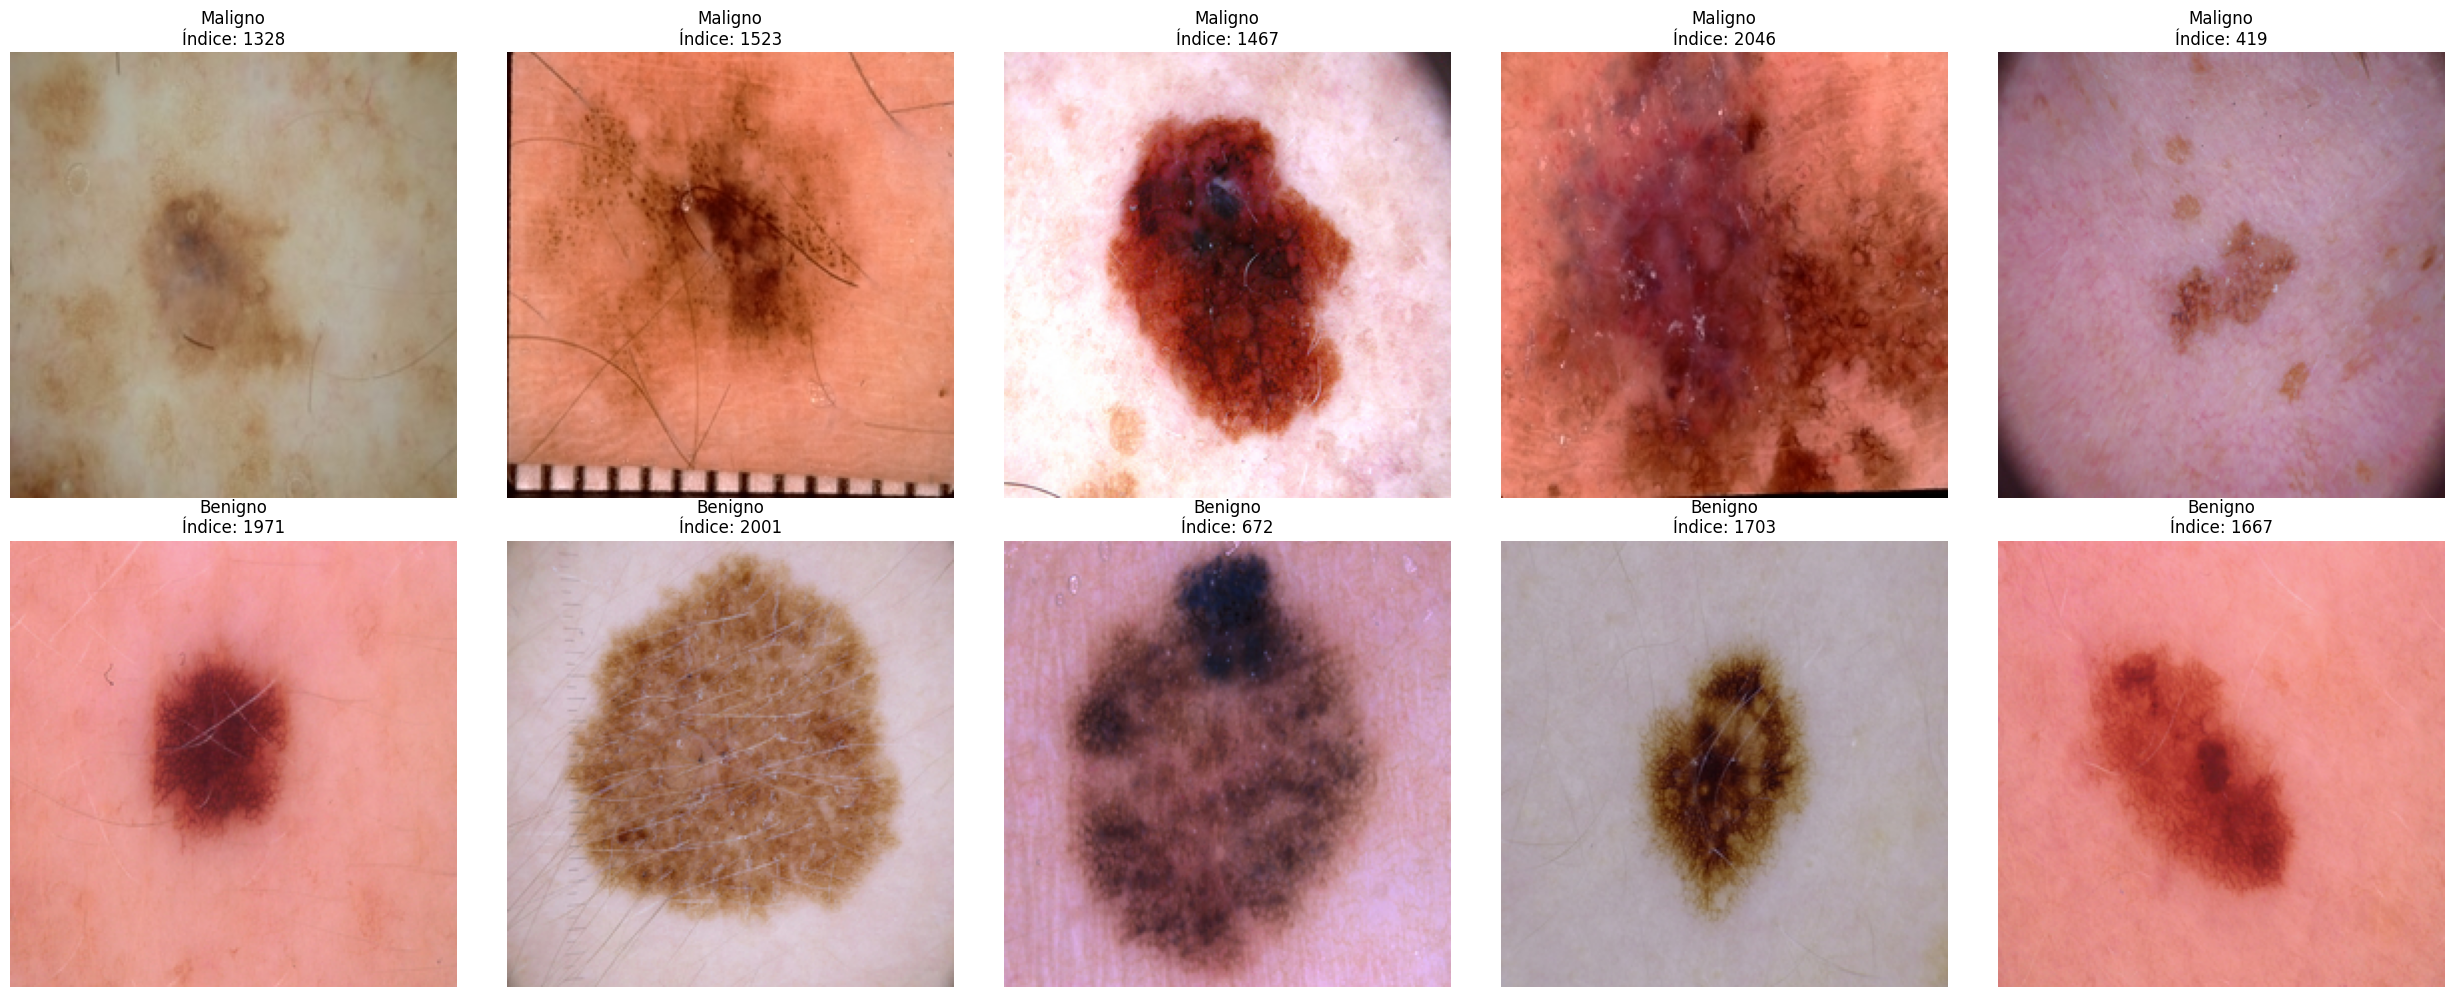


5. Metadatos del archivo:
- img_shape: [224 224   3]
- num_classes: 2
- train_size: 2109
- val_size: 528

Verificación completa!


True

In [22]:
"""
Verifico la integridad de los datos
"""

verify_saved_datasets_classification(num_samples=5)

### Unet + Clasificadora

In [23]:
def create_combined_model(unet_model):
    # Congelar todas las capas de U-Net excepto las últimas 3
    for layer in unet_model.layers[:-3]:
        layer.trainable = False

    # Obtener la salida de U-Net
    unet_output = unet_model.output

    # Aplicar tanto average como max pooling y concatenar
    gap = layers.GlobalAveragePooling2D()(unet_output)
    gmp = layers.GlobalMaxPooling2D()(unet_output)
    pooled = layers.Concatenate()([gap, gmp])

    # Red clasificadora más elaborada
    x = layers.Dense(512, activation='relu')(pooled)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    classification_output = layers.Dense(1, activation='sigmoid')(x)

    # Crear modelo combinado
    combined_model = Model(inputs=unet_model.input, outputs=classification_output)

    # Compilar con métricas útiles
    combined_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    return combined_model

In [24]:
import visualkeras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

print("Entrenando U-Net para segmentación...")
combined_model = create_combined_model(trained_unet_model)
combined_model.summary()

plot_model(
    combined_model,
    to_file="combined_model_architecture.png",
    show_shapes=True,
    show_layer_names=True
)


visualkeras.layered_view(combined_model, legend=True).save("combined_model_diagram.png")


Entrenando U-Net para segmentación...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 224, 224, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 224, 224, 64)   │         36,928 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 112, 112, 64)   │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 112, 112, 128)  │        147,584 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 56, 56, 128)    │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 56, 56, 256)    │        590,080 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 28, 28, 256)    │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 28, 28, 512)    │      2,359,808 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 28, 28, 512)    │              0 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 56, 56, 256)    │        524,544 │ dropout_1[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 56, 56, 512)    │              0 │ conv2d_transpose_3[0]… │
│ (Concatenate)             │                        │                │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 56, 56, 256)    │      1,179,904 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)   

 Total params: 7,875,010 (30.04 MB)

 Trainable params: 286,658 (1.09 MB)

 Non-trainable params: 7,588,352 (28.95 MB)

In [25]:
def train_combined_model(model, train_ds, val_ds):
    """
    Entrena el modelo combinado de UNet + Clasificación con configuración automática de parámetros

    Parámetros:
    - model: modelo combinado a entrenar
    - train_ds: dataset de entrenamiento
    - val_ds: dataset de validación

    Returns:
    - history: historial del entrenamiento
    - model: modelo entrenado
    """
    # Calcular steps automáticamente
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    validation_steps = tf.data.experimental.cardinality(val_ds).numpy()

    # Configurar parámetros de entrenamiento
    EPOCHS = 50  # Más épocas ya que tenemos early stopping
    BATCH_SIZE = 8  # Tamaño de batch mayor para clasificación
    INITIAL_LR = 1e-4  # Learning rate inicial

    # Compilar modelo con métricas
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    # Crear directorio para checkpoints
    checkpoint_dir = '/content/drive/My Drive/cancer/Clasifica/checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Callbacks
    callbacks = [
        # Guardar mejor modelo
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(checkpoint_dir, 'best_combined_model.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,  # Más paciencia para evitar parada prematura
            restore_best_weights=True,
            verbose=1
        ),
        # Reducción de learning rate
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=1
        )
    ]

    print(f"\nIniciando entrenamiento con:")
    print(f"- Steps por época: {steps_per_epoch}")
    print(f"- Steps de validación: {validation_steps}")
    print(f"- Learning rate inicial: {INITIAL_LR}")
    print(f"- Batch size: {BATCH_SIZE}")
    print(f"- Épocas máximas: {EPOCHS}")

    # Entrenar el modelo
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks
    )

    # Función para visualizar resultados
    def plot_training_history_combined(history):
        metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
        fig, axes = plt.subplots(3, 2, figsize=(15, 18))
        axes = axes.ravel()

        for idx, metric in enumerate(metrics):
            if metric in history.history:
                axes[idx].plot(
                    history.history[metric],
                    label=f'Training {metric.capitalize()}'
                )
                axes[idx].plot(
                    history.history[f'val_{metric}'],
                    label=f'Validation {metric.capitalize()}'
                )
                axes[idx].set_title(f'Model {metric.capitalize()}')
                axes[idx].set_xlabel('Epoch')
                axes[idx].set_ylabel(metric.capitalize())
                axes[idx].legend()
                axes[idx].grid(True)

        # Añadir curva ROC en el último subplot si hay espacio
        if len(metrics) < 6:
            last_epoch_val_labels = []
            last_epoch_val_preds = []

            for batch in val_ds:
                images, labels = batch
                preds = model.predict(images, verbose=0)
                last_epoch_val_labels.extend(labels.numpy())
                last_epoch_val_preds.extend(preds.flatten())

            fpr, tpr, _ = roc_curve(last_epoch_val_labels, last_epoch_val_preds)
            roc_auc = auc(fpr, tpr)

            axes[5].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
            axes[5].plot([0, 1], [0, 1], 'k--')
            axes[5].set_xlim([0.0, 1.0])
            axes[5].set_ylim([0.0, 1.05])
            axes[5].set_xlabel('False Positive Rate')
            axes[5].set_ylabel('True Positive Rate')
            axes[5].set_title('ROC Curve (Last Epoch)')
            axes[5].legend(loc="lower right")
            axes[5].grid(True)

        plt.tight_layout()
        plt.show()

    # Mostrar gráficas
    plot_training_history_combined(history)

    # Imprimir resumen del entrenamiento
    print("\nResumen del entrenamiento:")
    print(f"Épocas completadas: {len(history.history['loss'])}")
    print(f"Mejor precisión de validación: {max(history.history['val_accuracy']):.4f}")
    print(f"Mejor AUC de validación: {max(history.history['val_auc']):.4f}")
    print(f"Mejor precisión (precision) de validación: {max(history.history['val_precision']):.4f}")
    print(f"Mejor recall de validación: {max(history.history['val_recall']):.4f}")
    print(f"Pérdida final de validación: {min(history.history['val_loss']):.4f}")

    return history, model

# Ejemplo de uso:
# history, trained_model = train_combined_model(combined_model, train_ds, val_ds)

In [26]:
def evaluate_model_on_test_data(model, test_ds):
    """
    Evalúa el modelo en el conjunto de prueba y muestra métricas detalladas

    Args:
        model: Modelo entrenado
        test_ds: Dataset de prueba
    """
    # Evaluar modelo
    results = model.evaluate(test_ds, verbose=0)
    print("\nResultados en conjunto de prueba:")
    for name, value in zip(model.metrics_names, results):
        print(f"{name}: {value:.4f}")

    # Obtener predicciones
    all_labels = []
    all_preds = []

    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.flatten())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Calcular y mostrar matriz de confusión
    pred_classes = (all_preds > 0.5).astype(int)
    cm = confusion_matrix(all_labels, pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.show()

    # Mostrar curva ROC
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


Iniciando entrenamiento con:
- Steps por época: 66
- Steps de validación: 17
- Learning rate inicial: 0.0001
- Batch size: 8
- Épocas máximas: 50
Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5147 - auc: 0.5048 - loss: 0.8704 - precision: 0.4566 - recall: 0.2737   
Epoch 1: val_accuracy improved from -inf to 0.53409, saving model to /content/drive/My Drive/cancer/Clasifica/checkpoints/best_combined_model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.5150 - auc: 0.5052 - loss: 0.8698 - precision: 0.4570 - recall: 0.2743 - val_accuracy: 0.5341 - val_auc: 0.6412 - val_loss: 0.6892 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.5754 - auc: 0.5986 - loss: 0.7435 - precision: 0.5375 - recall: 0.3875
Epoch 2: val_accuracy did not improve from 0.53409
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 469ms/step - accuracy: 0.5755 - auc: 0.5986 - loss: 0.7436 - precision: 0.5376 - re

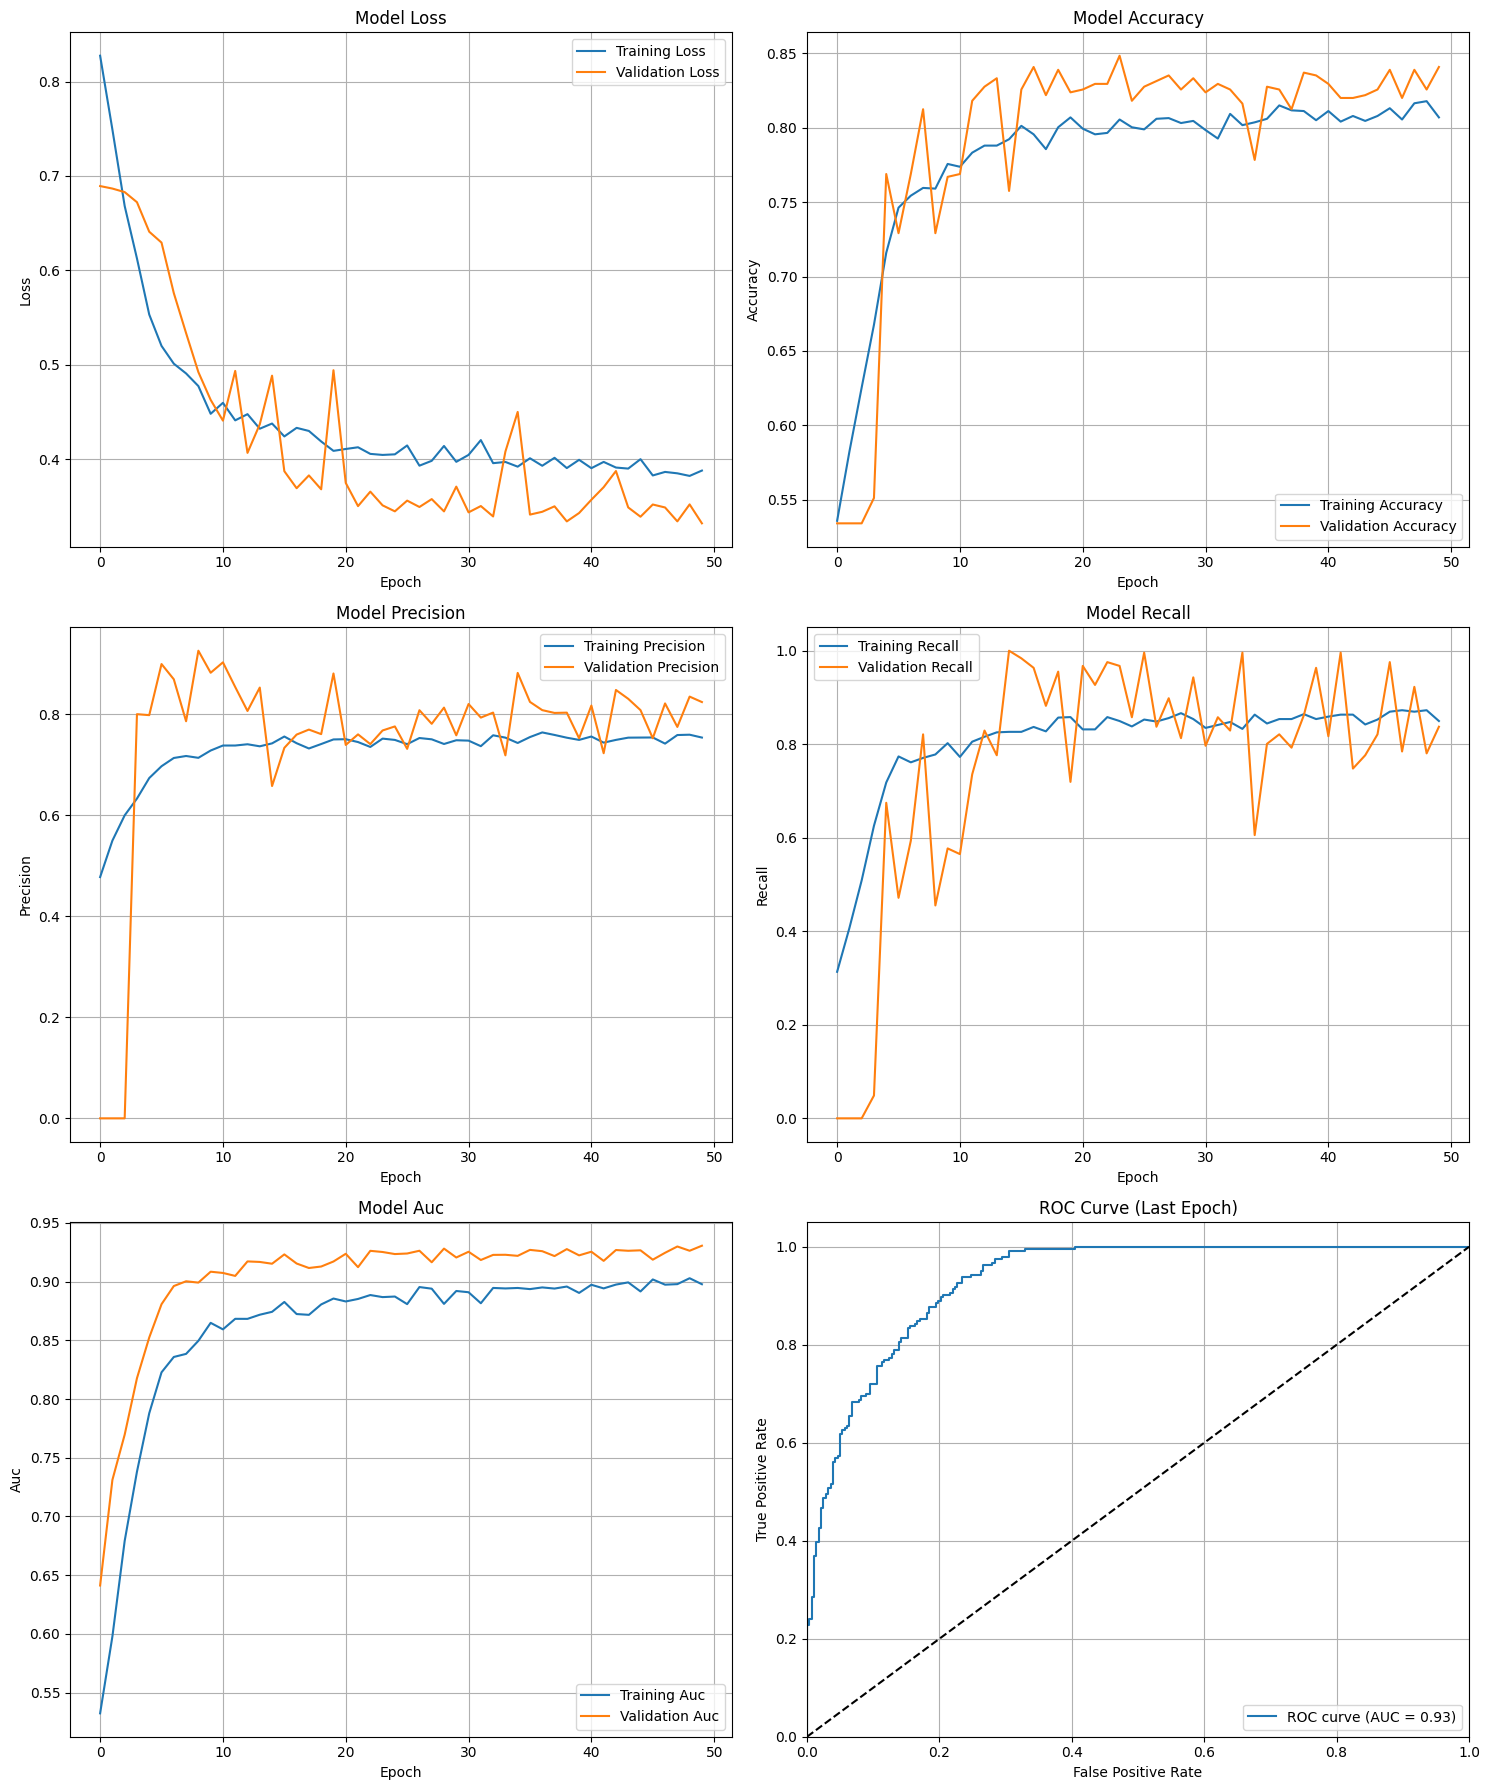


Resumen del entrenamiento:
Épocas completadas: 50
Mejor precisión de validación: 0.8485
Mejor AUC de validación: 0.9305
Mejor precisión (precision) de validación: 0.9256
Mejor recall de validación: 1.0000
Pérdida final de validación: 0.3319


In [ ]:
history, trained_combined_model = train_combined_model(combined_model, train_ds, val_ds)

In [ ]:
print(f"Mejor accuracy: {max(history.history['val_accuracy'])}")


Mejor accuracy: 0.8484848737716675


In [27]:
def verify_models(unet_model=None, combined_model=None, test_ds=None):
    """
    Verifica el funcionamiento de los modelos cargados

    Args:
        unet_model: Modelo U-Net cargado (opcional)
        combined_model: Modelo combinado cargado (opcional)
        test_ds: Dataset de prueba
    """
    if test_ds is None:
        print("⚠️ No se proporcionó dataset de prueba. Solo se verificará la carga de modelos.")
        return

    print("\nVerificando modelos cargados...")

    # Verificar U-Net si está disponible
    if unet_model is not None:
        print("\n1. Verificación de U-Net:")
        try:
            # Evaluar modelo
            results = unet_model.evaluate(test_ds, verbose=0)
            print("\nMétricas del modelo U-Net:")
            for name, value in zip(unet_model.metrics_names, results):
                print(f"- {name}: {value:.4f}")

            # Mostrar ejemplo de segmentación
            for images, masks in test_ds.take(1):
                pred_masks = unet_model.predict(images, verbose=0)

                # Mostrar ejemplo
                plt.figure(figsize=(15, 5))
                for i in range(min(3, len(images))):
                    # Imagen original
                    plt.subplot(1, 3, 1)
                    plt.imshow(images[i])
                    plt.title('Imagen Original')
                    plt.axis('off')

                    # Máscara real
                    plt.subplot(1, 3, 2)
                    plt.imshow(masks[i, :, :, 0], cmap='gray')
                    plt.title('Máscara Real')
                    plt.axis('off')

                    # Máscara predicha
                    plt.subplot(1, 3, 3)
                    plt.imshow(pred_masks[i, :, :, 0], cmap='gray')
                    plt.title('Máscara Predicha')
                    plt.axis('off')

                    break

                plt.tight_layout()
                plt.show()
                break

            print("✓ U-Net verificado correctamente")

        except Exception as e:
            print(f"❌ Error al verificar U-Net: {str(e)}")

    # Verificar modelo combinado si está disponible
    if combined_model is not None:
        print("\n2. Verificación del modelo combinado:")
        try:
            # Evaluar modelo
            results = combined_model.evaluate(test_ds, verbose=0)
            print("\nMétricas del modelo combinado:")
            for name, value in zip(combined_model.metrics_names, results):
                print(f"- {name}: {value:.4f}")

            # Mostrar algunas predicciones
            for images, labels in test_ds.take(1):
                predictions = combined_model.predict(images, verbose=0)

                print("\nPredicciones de ejemplo:")
                for i in range(min(5, len(predictions))):
                    pred_class = "Maligno" if predictions[i] > 0.5 else "Benigno"
                    true_class = "Maligno" if labels[i] == 1 else "Benigno"
                    print(f"\nImagen {i+1}:")
                    print(f"- Predicción: {pred_class} ({predictions[i][0]:.4f})")
                    print(f"- Verdadero: {true_class}")
                break

            print("✓ Modelo combinado verificado correctamente")

        except Exception as e:
            print(f"❌ Error al verificar modelo combinado: {str(e)}")

# Función para cargar y verificar ambos modelos
def load_and_verify_all_models(test_ds=None):
    """
    Carga y verifica tanto el modelo U-Net como el combinado

    Args:
        test_ds: Dataset de prueba (opcional)

    Returns:
        tuple: (unet_model, combined_model)
    """
    # Cargar modelos
    unet_model = load_pretrained_unet()
    combined_model = load_pretrained_combined_model()

    # Verificar modelos
    if test_ds is not None:
        verify_models(unet_model, combined_model, test_ds)

    return unet_model, combined_model

In [33]:
unet_model, combined_model = load_and_verify_all_models()


Cargando modelo U-Net pre-entrenado...
✓ Modelo U-Net cargado exitosamente!
Cargando modelo combinado pre-entrenado...
Cargando modelo U-Net pre-entrenado...
✓ Modelo U-Net cargado exitosamente!
✓ Modelo combinado cargado exitosamente!


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Cargar imagenes a colab

In [34]:
from IPython.display import display, HTML
from google.colab import files
import tempfile
import os

def predict_local_image(model, img_size=224):
    """
    Permite subir una imagen desde el computador local a Colab y realiza la predicción

    Args:
        model: Modelo combinado entrenado
        img_size: Tamaño de la imagen esperado por el modelo
    """
    try:
        # Mostrar mensaje de carga
        display(HTML(
            '<div style="background-color:#f8f9fa;padding:10px;border-radius:5px;margin:10px 0;">'
            '<h3 style="color:#0056b3;margin:0;">📁 Selecciona una imagen para analizar</h3>'
            '<p style="margin:5px 0 0 0;">Formatos soportados: jpg, jpeg, png</p>'
            '</div>'
        ))

        # Subir archivo
        uploaded = files.upload()

        if not uploaded:
            print("No se seleccionó ninguna imagen.")
            return None

        # Procesar cada imagen subida (normalmente será una)
        results = []
        for filename, content in uploaded.items():
            # Guardar archivo temporalmente
            with tempfile.NamedTemporaryFile(delete=False, suffix=os.path.splitext(filename)[1]) as tmp_file:
                tmp_file.write(content)
                temp_path = tmp_file.name

            try:
                # Cargar y preprocesar la imagen
                img = tf.keras.preprocessing.image.load_img(
                    temp_path,
                    target_size=(img_size, img_size)
                )
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = img_array / 255.0
                img_array = np.expand_dims(img_array, axis=0)

                # Realizar predicción
                prediction = model.predict(img_array, verbose=0)[0][0]
                class_pred = "Maligno" if prediction > 0.5 else "Benigno"
                probability = prediction if prediction > 0.5 else 1 - prediction

                # Visualizar resultados
                plt.figure(figsize=(10, 8))

                # Mostrar imagen
                plt.imshow(img)

                # Configurar título y estilo
                title = f'Predicción: {class_pred}\nProbabilidad: {probability:.2%}'
                plt.title(title, pad=20, size=14, color='white' if class_pred == "Maligno" else 'black')

                # Configurar borde según la predicción
                border_color = 'red' if class_pred == "Maligno" else 'green'
                border_width = 5
                for spine in plt.gca().spines.values():
                    spine.set_color(border_color)
                    spine.set_linewidth(border_width)

                # Configurar fondo según la predicción
                plt.gca().set_facecolor('mistyrose' if class_pred == "Maligno" else 'honeydew')

                # Añadir texto con detalles
                plt.figtext(
                    0.02, 0.02,
                    f'Nombre archivo: {filename}\n'
                    f'Dimensiones: {img_size}x{img_size}\n'
                    f'Probabilidad exacta: {prediction:.4f}',
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8)
                )

                plt.axis('off')
                plt.tight_layout()
                plt.show()

                # Mostrar resumen de resultados
                print("\n" + "="*50)
                print("Resultados del análisis:")
                print("="*50)
                print(f"📄 Archivo: {filename}")
                print(f"🔍 Clasificación: {class_pred}")
                print(f"📊 Probabilidad: {probability:.2%}")
                print(f"📏 Dimensiones: {img_size}x{img_size}")
                if class_pred == "Maligno":
                    print("\n⚠️ IMPORTANTE: Esta es solo una predicción. Por favor, consulte con un profesional médico.")
                print("="*50)

                results.append({
                    "filename": filename,
                    "class": class_pred,
                    "probability": probability,
                    "raw_prediction": prediction
                })

            except Exception as e:
                print(f"\n❌ Error al procesar {filename}: {str(e)}")

            finally:
                # Limpiar archivo temporal
                os.unlink(temp_path)

        return results[0] if len(results) == 1 else results

    except Exception as e:
        print(f"\n❌ Error general: {str(e)}")
        return None

# Función para realizar múltiples predicciones
def predict_multiple_local_images(model, img_size=224):
    """
    Permite subir múltiples imágenes desde el computador local a Colab y realiza las predicciones

    Args:
        model: Modelo combinado entrenado
        img_size: Tamaño de la imagen esperado por el modelo
    """
    display(HTML(
        '<div style="background-color:#f8f9fa;padding:10px;border-radius:5px;margin:10px 0;">'
        '<h3 style="color:#0056b3;margin:0;">📁 Selecciona múltiples imágenes para analizar</h3>'
        '<p style="margin:5px 0 0 0;">Puedes seleccionar varias imágenes manteniendo presionada la tecla Ctrl</p>'
        '</div>'
    ))

    uploaded = files.upload()

    if not uploaded:
        print("No se seleccionaron imágenes.")
        return None

    n_images = len(uploaded)
    n_cols = min(3, n_images)
    n_rows = (n_images + n_cols - 1) // n_cols

    plt.figure(figsize=(6*n_cols, 6*n_rows))

    results = []
    for idx, (filename, content) in enumerate(uploaded.items()):
        with tempfile.NamedTemporaryFile(delete=False, suffix=os.path.splitext(filename)[1]) as tmp_file:
            tmp_file.write(content)
            temp_path = tmp_file.name

        try:
            # Procesar imagen
            img = tf.keras.preprocessing.image.load_img(
                temp_path,
                target_size=(img_size, img_size)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Predicción
            prediction = model.predict(img_array, verbose=0)[0][0]
            class_pred = "Maligno" if prediction > 0.5 else "Benigno"
            probability = prediction if prediction > 0.5 else 1 - prediction

            # Visualizar
            plt.subplot(n_rows, n_cols, idx + 1)
            plt.imshow(img)
            plt.title(f'{filename}\n{class_pred} ({probability:.2%})')

            # Borde según predicción
            border_color = 'red' if class_pred == "Maligno" else 'green'
            for spine in plt.gca().spines.values():
                spine.set_color(border_color)
                spine.set_linewidth(3)

            plt.axis('off')

            results.append({
                "filename": filename,
                "class": class_pred,
                "probability": probability
            })

        except Exception as e:
            print(f"\n❌ Error al procesar {filename}: {str(e)}")

        finally:
            os.unlink(temp_path)

    plt.tight_layout()
    plt.show()

    # Mostrar resumen
    print("\n📊 Resumen de predicciones:")
    print("="*50)
    for result in results:
        print(f"📄 {result['filename']}: {result['class']} ({result['probability']:.2%})")
    print("="*50)

    return results

Saving 216.jpg to 216 (2).jpg


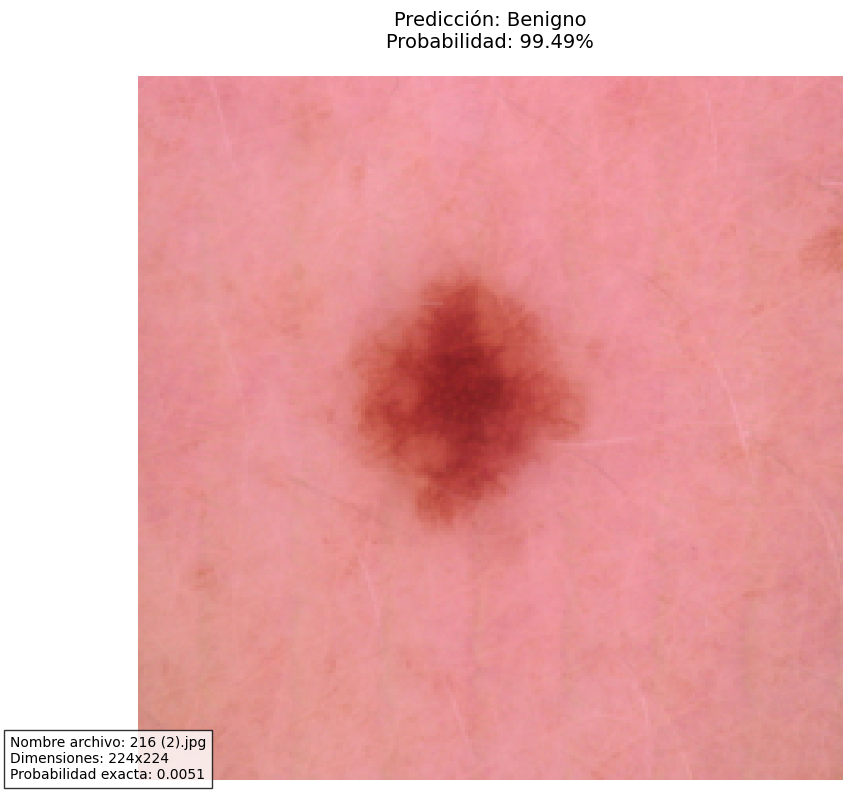


Resultados del análisis:
📄 Archivo: 216 (2).jpg
🔍 Clasificación: Benigno
📊 Probabilidad: 99.49%
📏 Dimensiones: 224x224


{'filename': '216 (2).jpg',
 'class': 'Benigno',
 'probability': 0.9949247180484235,
 'raw_prediction': 0.005075282}

In [41]:
predict_local_image(combined_model)